# Numerical Stability and Initialization

:label:`chapter_numerical_stability`


In the past few sections, each model that we implemented
required initializing our parameters according to some specified distribution.
However, until now, we glossed over the details,
taking the initialization hyperparameters for granted.
You might even have gotten the impression that these choices
are not especially important.
However, the choice of initialization scheme
plays a significant role in neural network learning,
and can prove essentially to maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the activation function.
Which nonlinear activation function we choose,
and how we decide to initialize our parameters
can play a crucial role in making
the optimization algorithm converge rapidly.
Failure to be mindful of these issues
can lead to either exploding or vanishing gradients.
In this section, we delve into these topics with greater detail
and discuss some useful heuristics that you may use
frequently throughout your career in deep learning.


## Vanishing and Exploding Gradients

Consider a deep network with $d$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
Each layer satisfies:

$$\mathbf{h}^{t+1} = f_t (\mathbf{h}^t) \text{ and thus } \mathbf{o} = f_d \circ \ldots \circ f_1(\mathbf{x})$$

If all activations and inputs are vectors,
we can write the gradient of $\mathbf{o}$
with respect to any set of parameters $\mathbf{W}_t$
associated with the function $f_t$ at layer $t$ simply as

$$\partial_{\mathbf{W}_t} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{d-1}} \mathbf{h}^d}_{:= \mathbf{M}_d} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{t}} \mathbf{h}^{t+1}}_{:= \mathbf{M}_t} \underbrace{\partial_{\mathbf{W}_t} \mathbf{h}^t}_{:= \mathbf{v}_t}.$$

In other words, it is the product of $d-t$ matrices
$\mathbf{M}_d \cdot \ldots \cdot \mathbf{M}_t$
and the gradient vector $\mathbf{v}_t$.
What happens is similar to the situation
when we experienced numerical underflow
when multiplying too many probabilities.
At the time, we were able to mitigate the problem
by switching from into log-space, i.e. by shifting the problem
from the mantissa to the exponent of the numerical representation. Unfortunately the problem outlined in the equation above is much more serious:
initially the matrices $M_t$ may well have a wide variety of eigenvalues.
They might be small, they might be large, and in particular,
their product might well be *very large* or *very small*.
This is not (only) a problem of numerical representation
but it means that the optimization algorithm is bound to fail.
It receives gradients that are either
excessively large or excessively small.
As a result the steps taken are either
(i) excessively large (the *exploding* gradient problem),
in which case the parameters blow up in magnitude rendering the model useless,
or (ii) excessively small, (the *vanishing gradient problem*),
in which case the parameters hardly move at all,
and thus the learning process makes no progress.


### Vanishing Gradients

One major culprit in the vanishing gradient problem
is the choices of the activation functions $\sigma$
that are interleaved with the linear operations in each layer.
Historically, a the sigmoid function $rac{1}{1 + e^{-x}}$(introduced in :numref:`chapter_mlp`)
was a popular choice owing to its similarity to a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that either fire or do not fire
(biological neurons do not partially fire) seemed appealing.
Let's take a closer look at the function
to see why picking it might be problematic
vis-a-vis vanishing gradients.

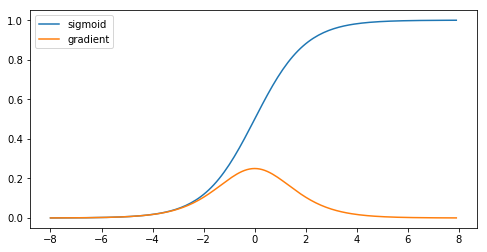

In [2]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt

x = torch.arange(-8.0,8.0,0.1)
x.requires_grad_(True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

with torch.no_grad():
    plt.figure(figsize=(8,4))
    plt.plot(x.detach().numpy(),y.detach().numpy())
    plt.plot(x.detach().numpy(),x.grad.numpy())
    plt.legend(['sigmoid','gradient'])
    plt.show()

As we can see, the gradient of the sigmoid vanishes
both when its inputs are large and when they are small.
Moreover, when we excecute backward propagation, due to the chain rule,
this means that unless we are in the Goldilocks zone,
where the inputs to most of the sigmoids are in the range of, say $[-4, 4]$,
the gradients of the overall product may vanish.
When we have many layers, unless we are especially careful,
we are likely to find that our gradient is cut off at *some* layer.
Before ReLUs ($\max(0,x)$) were proposed
as an alternative to squashing functions,
this problem used to plague deep network training.
As a consequence, ReLUs have become
the default choice when designing activation functions in deep networks.


### Exploding Gradients

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw $100$ Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
If this were to happen to us with a deep network,
we would have no realistic chance of getting
a gradient descent optimizer to converge.

In [3]:
M = torch.rand(4,4)
print('A single matrix \n',M)
for i in range(100):
    M = torch.mm(M,torch.randn(4,4))
print('After multiplying 100 matrices\n',M)

A single matrix 
 tensor([[0.8210, 0.3891, 0.5661, 0.1407],
        [0.5208, 0.7289, 0.4124, 0.7274],
        [0.5456, 0.8456, 0.3011, 0.9407],
        [0.4575, 0.4993, 0.4596, 0.8236]])
After multiplying 100 matrices
 tensor([[4.1657e+26, 2.5340e+26, 1.4468e+27, 4.0063e+26],
        [4.8251e+26, 2.9351e+26, 1.6759e+27, 4.6405e+26],
        [4.7927e+26, 2.9154e+26, 1.6646e+27, 4.6093e+26],
        [4.3570e+26, 2.6504e+26, 1.5133e+27, 4.1904e+26]])


### Symmetry

Another problem in deep network design
is the symmetry inherent in their parametrization.
Assume that we have a deep network
with one hidden layer with two units, say $h_1$ and $h_2$.
In this case, we could permute the weights $\mathbf{W}_1$
of the first layer and likewise permute the weights of the output layer
to obtain the same function function.
There is nothing special differentiating
the first hidden unit vs the second hidden unit.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Imagine what would happen if we initialized
all of the parameters of some layer as $\mathbf{W}_l = c$
for some constant $c$.
In this case, the gradients for all dimensions are identical:
thus not only would each unit take the same value,
but it would receive the same update.
Stochastic gradient descent would never break the symmetry on its own
and we might never be able to realize the networks expressive power.
The hidden layer would behave as if it had only a single unit.
As an aside, note that while SGD would not break this symmetry,
dropout regularization would!



## Parameter Initialization

One way of addressing, or at least mitigating the issues raised above
is through careful initialization of the weight vectors.
This way we can ensure that (at least initially) the gradients do not vanish a
and that they maintain a reasonable scale
where the network weights do not diverge.
Additional care during optimization and suitable regularization
ensures that things never get too bad.


### Default Initialization

Each Pytorch layer implements the method `reset_parameters`
which is called at the end of the layer
initialization to initialize the weights.


If the user wishes to initialize manually, for Single
Layer, functions from `torch.nn.init` 
are used. For instance: 


In [5]:
conv1 = torch.nn.Conv2d(2,2,1)
torch.nn.init.xavier_uniform_(conv1.weight)

Parameter containing:
tensor([[[[ 0.5463]],

         [[ 0.0279]]],


        [[[ 1.1137]],

         [[-0.0143]]]], requires_grad=True)

A function can be passed to `torch.nn.Module.apply()`. It 
will recursively initialize the weights of `nn.Module` .

In [7]:
import torch.nn as nn
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

### Xavier Initialization

Let's look at the scale distribution of the activations of the hidden units $h_{i}$ for some layer. They are given by

$$h_{i} = \sum_{j=1}^{n_\mathrm{in}} W_{ij} x_j$$

The weights $W_{ij}$ are all drawn independently from the same distribution. Furthermore, let's assume that this distribution
has zero mean and variance $\sigma^2$
(this doesn't mean that the distribution has to be Gaussian,
just that mean and variance need to exist).
We don't really have much control
over the inputs into the layer $x_j$
but let's proceed with the somewhat unrealistic assumption
that they also have zero mean and variance $\gamma^2$
and that they're independent of $\mathbf{W}$.
In this case, we can compute mean and variance of $h_i$ as follows:

$$
\begin{aligned}
    \mathbf{E}[h_i] & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W_{ij} x_j] = 0 \\
    \mathbf{E}[h_i^2] & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W^2_{ij} x^2_j] \\
        & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W^2_{ij}] \mathbf{E}[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}
$$

One way to keep the variance fixed is to set $n_\mathrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the top layers.
That is, instead of $\mathbf{W} \mathbf{w}$,
we need to deal with $\mathbf{W}^\top \mathbf{g}$,
where $\mathbf{g}$ is the incoming gradient from the layer above.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\mathrm{out} \sigma^2 = 1$.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{aligned}.
$$

This is the reasoning underlying the eponymous Xavier initialization,
proposed by [Xavier Glorot and Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) in 2010.
It works well enough in practice.
For Gaussian random variables, the Xavier initialization
picks a normal distribution with zero mean
and variance $\sigma^2 = 2/(n_\mathrm{in} + n_\mathrm{out})$.
For uniformly distributed random variables $U[-a, a]$,
note that their variance is given by $a^2/3$.
Plugging $a^2/3$ into the condition on $\sigma^2$ yields
that we should initialize uniformly with
$U\left[-\sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}, \sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}\right]$.

### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
In fact, Pytorch has an entire `torch.nn.init` module
implementing over a dozen different heuristics.
Moreover, intialization continues to be a hot area of inquiry
within research into the fundamental theory of neural network optimization.
Some of these heuristics are especially suited
for when parameters are tied
(i.e., when parameters of in different parts the network are shared),
for superresolution, sequence models, and related problems.
We recommend that the interested reader take a closer look
at what is offered as part of this module,
and investigate the recent research on parameter initialization.
Perhaps you may come across a recent clever idea
and contribute its implementation to Pytorch,
or you may even invent your own scheme!


## Summary

* Vanishing and exploding gradients are common issues in very deep networks, unless great care is taking to ensure that gradients and parameters remain well controlled.
* Initialization heuristics are needed to ensure that at least the initial gradients are neither too large nor too small.
* The ReLU addresses one of the vanishing gradient problems, namely that gradients vanish for very large inputs. This can accelerate convergence significantly.
* Random initialization is key to ensure that symmetry is broken before optimization.

## Exercises

1. Can you design other cases of symmetry breaking besides the permutation symmetry?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on LARS by [You, Gitman and Ginsburg, 2017](https://arxiv.org/pdf/1708.03888.pdf) for inspiration.
